# Initialisation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import sqlite3
from time import time
from tqdm import tqdm

from geopy.distance import distance

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

Mounted at /content/drive


In [2]:
path_data = '/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 5/olist_data/'
olist_customers_dataset = pd.read_csv(path_data + 'olist_customers_dataset.csv',sep=',')
olist_geolocation_dataset = pd.read_csv(path_data + 'olist_geolocation_dataset.csv',sep=',')
olist_order_items_dataset = pd.read_csv(path_data + 'olist_order_items_dataset.csv',sep=',')
olist_order_payments_dataset = pd.read_csv(path_data + 'olist_order_payments_dataset.csv',sep=',')
olist_orders_dataset = pd.read_csv(path_data + 'olist_orders_dataset.csv',sep=',')
olist_products_dataset = pd.read_csv(path_data + 'olist_products_dataset.csv',sep=',')
olist_sellers_dataset = pd.read_csv(path_data + 'olist_sellers_dataset.csv',sep=',')
product_category_name_translation = pd.read_csv(path_data + 'product_category_name_translation.csv',sep=',')
olist_order_reviews_dataset = pd.read_csv(path_data + 'olist_order_reviews_dataset.csv',sep=',')

# SQL feature engineering

In [40]:
# petite vérification que les tables CVS et .db sont identique (test sur le nb de customer id)

conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT customer_id
FROM customers;
"""

test = pd.read_sql_query(sql, conn)

In [41]:
olist_customers_dataset['customer_id'].shape, test.shape

((99441,), (99441, 1))

### Noms des tables

In [42]:
conn = sqlite3.connect(path_data + 'olist.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
tables

[('customers',),
 ('geoloc',),
 ('order_items',),
 ('order_pymts',),
 ('order_reviews',),
 ('orders',),
 ('products',),
 ('sellers',),
 ('translation',),
 ('customers_freq_table',),
 ('seniority_table',),
 ('customers_seniority_table',),
 ('nb_order_table',),
 ('freq_table',),
 ('customers_seniority_freq_table',),
 ('montant_table',),
 ('customers_seniority_freq_montant_table',),
 ('recency_table',),
 ('customers_RFMS_table',),
 ('satisfaction_table',),
 ('customers_RFMSS_table',)]

On joins toutes les tables dans un premier temps avant de supprimer les colonnes non pertinentes pour le clustering.

### Frequence

#### correction

In [5]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    )
  SELECT customer_unique_id, COUNT(order_id) AS frequency
  FROM customer_order_table
  GROUP BY customer_unique_id;
"""
pd.read_sql_query(sql, conn)

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,1
94986,fffea47cd6d3cc0a88bd621562a9d061,1
94987,ffff371b4d645b6ecea244b27531430a,1
94988,ffff5962728ec6157033ef9805bacc48,1


In [6]:
Frequency_table = pd.read_sql_query(sql, conn)
Frequency_table['frequency'].value_counts()

1     92102
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: frequency, dtype: int64

In [45]:
Frequency_table.isna().mean()

customer_unique_id    0.0
frequency             0.0
dtype: float64

In [7]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    )
  SELECT customer_unique_id, COUNT(order_id) AS frequency
  FROM customer_order_table
  GROUP BY customer_unique_id;
"""
test1 = pd.read_sql_query(sql, conn)
test1.describe()

,frequency
count,94990.000000
mean,1.033867
std,0.210826
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,16.000000


In [8]:
# fonction qui recalcul les features de segmentation principale en SQL
# dans l'ordre RFMSI
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, o.order_purchase_timestamp, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    ),
  value_table AS (
    SELECT o.*, v.payment_value, v.payment_installments
    FROM order_pymts v
    INNER JOIN customer_order_table o
    ON o.order_id = v.order_id
  ),
  main_table AS (
    SELECT v.*, r.review_score
    FROM value_table v
    INNER JOIN order_reviews AS r
    ON v.order_id = r.order_id
  )
  SELECT customer_unique_id,
          MIN(julianday((SELECT MAX(order_purchase_timestamp) FROM main_table)) - julianday(order_purchase_timestamp)) AS recency,
          COUNT(order_id) AS frequency,
          SUM(payment_value) as monetary,
          AVG(review_score) AS satisfaction_mean,
          AVG(payment_installments) AS installment_mean
  FROM main_table
  GROUP BY customer_unique_id;
"""
test2 = pd.read_sql_query(sql, conn)
test2.describe()

,recency,frequency,monetary,satisfaction_mean,installment_mean
count,94304.000000,94304.000000,94304.000000,94304.000000,94304.000000
mean,242.933499,1.085765,166.160287,4.114090,2.900216
std,152.999640,0.489417,226.992977,1.315998,2.675390
min,0.000000,1.000000,9.590000,1.000000,0.000000
25%,118.835191,1.000000,63.100000,4.000000,1.000000
50%,223.701817,1.000000,107.950000,5.000000,2.000000
75%,351.847775,1.000000,183.530000,5.000000,4.000000
max,728.494190,33.000000,13664.080000,5.000000,24.000000


#### faux

In [46]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
    SELECT customer_id, COUNT(order_id) AS nbr_order
    FROM orders
    GROUP BY customer_id;
"""
pd.read_sql_query(sql, conn)['nbr_order'].value_counts()

#nb_order_df = pd.read_sql_query(sql, conn)
#nb_order_df.to_sql('nb_order_table', conn, if_exists='replace', index=False)


1    99441
Name: nbr_order, dtype: int64

In [47]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
    SELECT customer_id, COUNT(order_id) AS nbr_order
    FROM orders
    GROUP BY customer_id;
"""
pd.read_sql_query(sql, conn)['nbr_order'].value_counts()

#nb_order_df = pd.read_sql_query(sql, conn)
#nb_order_df.to_sql('nb_order_table', conn, if_exists='replace', index=False)


1    99441
Name: nbr_order, dtype: int64

In [48]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH count_order_table AS (
    SELECT customer_id, COUNT(order_id) AS nbr_order
    FROM orders
    WHERE order_status NOT LIKE 'canceled'
    GROUP BY customer_id
    )
  SELECT a.*, b.customer_unique_id, b.customer_id
  FROM count_order_table a
  INNER JOIN customers AS b
  ON a.customer_id = b.customer_id
  GROUP BY b.customer_unique_id;
"""
pd.read_sql_query(sql, conn)

#nb_order_df = pd.read_sql_query(sql, conn)
#nb_order_df.to_sql('nb_order_table', conn, if_exists='replace', index=False)


,customer_id,nbr_order,customer_unique_id,customer_id
0,fadbb3709178fc513abc1b2670aa1ad2,1,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2
1,4cb282e167ae9234755102258dd52ee8,1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8
2,9b3932a6253894a02c1df9d19004239f,1,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f
3,914991f0c02ef0843c0e7010c819d642,1,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642
4,47227568b10f5f58a524a75507e6992c,1,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c
...,...,...,...,...
95555,74be082247cd677a147d83ee670e9d53,1,fffcf5a5ff07b0908bd4e2dbc735a684,74be082247cd677a147d83ee670e9d53
95556,0ecf8e0a08148af0bf313184f167670a,1,fffea47cd6d3cc0a88bd621562a9d061,0ecf8e0a08148af0bf313184f167670a
95557,27f584b0f1dc4e610065c240f68b6be0,1,ffff371b4d645b6ecea244b27531430a,27f584b0f1dc4e610065c240f68b6be0
95558,832a3b0254347d409512ae92eaf154a6,1,ffff5962728ec6157033ef9805bacc48,832a3b0254347d409512ae92eaf154a6


In [49]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT customer_id, COUNT(order_id) AS nbr_order
FROM orders
WHERE order_status NOT LIKE 'canceled'
GROUP BY customer_id;
"""

nb_order_df = pd.read_sql_query(sql, conn)
nb_order_df.to_sql('nb_order_table', conn, if_exists='replace', index=False)

98816

In [50]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT customer_id, COUNT(order_id) AS nbr_order
FROM orders
WHERE order_status NOT LIKE 'canceled'
GROUP BY customer_id;
"""

pd.read_sql_query(sql, conn)


,customer_id,nbr_order
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
98811,fffecc9f79fd8c764f843e9951b11341,1
98812,fffeda5b6d849fbd39689bb92087f431,1
98813,ffff42319e9b2d713724ae527742af25,1
98814,ffffa3172527f765de70084a7e53aae8,1


In [51]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT *
FROM nb_order_table;
"""
test = pd.read_sql_query(sql, conn)

In [52]:
test.nbr_order.max()

1

In [53]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT s.customer_id, (nb.nbr_order/s.seniority_days)*30 as freq_month
FROM seniority_table s
LEFT JOIN nb_order_table nb ON nb.customer_id = s.customer_id;
"""

freq_df = pd.read_sql_query(sql, conn)
freq_df.to_sql('freq_table', conn, if_exists='replace', index=False)

99441

In [54]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT *
FROM freq_table;
"""

pd.read_sql_query(sql, conn)


,customer_id,freq_month
0,9ef432eb6251297304e76186b10a928d,0.089306
1,b0830fb4747a6c6d20dea0b8c802d7ef,0.740419
2,41ce2a54c0b03bf3443c3d931a367089,1.152980
3,f88197465ea7920adcdbec7375364d82,0.103961
4,8ab97904e6daea8866dbdbc4fb7aad2c,0.148889
...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,0.055252
99437,1fca14ff2861355f6e5f14306ff977a7,0.143651
99438,1aa71eb042121263aafbe80c1b562c9c,0.080696
99439,b331b74b18dc79bcdf6532d51e1637c1,0.126324


In [55]:
# join it to customers table
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT cst.*, f.freq_month
FROM customers_seniority_table cst
INNER JOIN freq_table f ON cst.customer_id=f.customer_id;
"""
#pd.read_sql_query(sql, conn)
customers_df_2 = pd.read_sql_query(sql, conn)
customers_df_2.to_sql('customers_seniority_freq_table', conn, if_exists='replace', index=False)

99441

In [56]:
# join it to customers table
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT *
FROM customers_seniority_freq_table;
"""
pd.read_sql_query(sql, conn)


,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seniority_days,freq_month
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,474.750949,0.063191
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,233.512882,0.128473
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,106.707778,0.281142
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.708553,0.172703
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,35.969062,0.834050
...,...,...,...,...,...,...,...,...
99436,99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,148.721296,0.201720
99437,99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,152.032350,0.197326
99438,99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,147.538275,0.203337
99439,99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,303.498889,0.098847


### Montant

#### correction

In [57]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH value_table AS (
    SELECT v.order_id, v.payment_value, o.order_id
    FROM order_pymts v
    INNER JOIN orders o
    ON o.order_id = v.order_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  ),
  customer_order_table AS (
    SELECT c.customer_unique_id, c.customer_id, o.customer_id, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    )
  SELECT a.customer_unique_id, SUM(b.payment_value) as monetary
  FROM customer_order_table a
  INNER JOIN value_table b
  ON a.order_id = b.order_id
  GROUP BY a.customer_unique_id;
"""
pd.read_sql_query(sql, conn)
#montant_df = pd.read_sql_query(sql, conn)
#montant_df.to_sql('montant_table', conn, if_exists='replace', index=False)

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
94984,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
94985,fffea47cd6d3cc0a88bd621562a9d061,84.58
94986,ffff371b4d645b6ecea244b27531430a,112.46
94987,ffff5962728ec6157033ef9805bacc48,133.69


In [58]:
Monetary_table = pd.read_sql_query(sql, conn)

In [59]:
Monetary_table.isna().mean()

customer_unique_id    0.0
monetary              0.0
dtype: float64

#### faux

In [60]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT *
FROM montant_table;
"""

pd.read_sql_query(sql, conn)

,customer_id,montant
0,00012a2ce6f8dcda20d059ce98491703,89.80
1,000161a058600d5901f007fab4c27140,54.90
2,0001fd6190edaaf884bcaf3d49edf079,179.99
3,0002414f95344307404f0ace7a26f1d5,149.90
4,000379cdec625522490c315e70c7a9fb,93.00
...,...,...
98200,fffcb937e9dd47a13f05ecb8290f4d3e,78.00
98201,fffecc9f79fd8c764f843e9951b11341,54.90
98202,fffeda5b6d849fbd39689bb92087f431,47.90
98203,ffff42319e9b2d713724ae527742af25,199.90


In [61]:
# join it to customers table
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT cst.*, m.montant
FROM customers_seniority_freq_table cst
INNER JOIN montant_table m ON cst.customer_id=m.customer_id;
"""
#pd.read_sql_query(sql, conn)
customers_df_3 = pd.read_sql_query(sql, conn)
customers_df_3.to_sql('customers_seniority_freq_montant_table', conn, if_exists='replace', index=False)

98205

In [62]:
# join it to customers table
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT *
FROM customers_seniority_freq_montant_table;
"""
pd.read_sql_query(sql, conn)

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seniority_days,freq_month,montant
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,474.750949,0.063191,124.99
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,233.512882,0.128473,289.00
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,106.707778,0.281142,139.94
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.708553,0.172703,149.94
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,35.969062,0.834050,230.00
...,...,...,...,...,...,...,...,...,...
98200,99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,148.721296,0.201720,74.90
98201,99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,152.032350,0.197326,114.90
98202,99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,147.538275,0.203337,37.00
98203,99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,303.498889,0.098847,689.00


### Recence

#### correction

In [ ]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, c.customer_id, o.customer_id, o.order_purchase_timestamp
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    )
  SELECT customer_unique_id, MIN(julianday((SELECT MAX(order_purchase_timestamp) FROM customer_order_table)) - julianday(order_purchase_timestamp)) AS recency
  FROM customer_order_table
  GROUP BY customer_unique_id;

"""
pd.read_sql_query(sql, conn)

In [64]:
Recency_table = pd.read_sql_query(sql, conn)

In [65]:
Recency_table.isna().mean()

customer_unique_id    0.0
recency               0.0
dtype: float64

#### faux

In [66]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """

SELECT customer_id, MIN(julianday((SELECT MAX(order_purchase_timestamp) FROM orders WHERE order_status NOT LIKE 'canceled')) - julianday(order_purchase_timestamp)) AS recency
FROM orders
WHERE order_status NOT LIKE 'canceled'
GROUP BY customer_id;

"""
#pd.read_sql_query(sql, conn)
recency_df = pd.read_sql_query(sql, conn)
recency_df.to_sql('recency_table', conn, if_exists='replace', index=False)

98816

In [67]:
# join it to customers table
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT csfmt.*, r.recency
FROM customers_seniority_freq_montant_table csfmt
INNER JOIN recency_table r ON csfmt.customer_id=r.customer_id;
"""
#pd.read_sql_query(sql, conn)
customers_df_4 = pd.read_sql_query(sql, conn)
customers_df_4.to_sql('customers_RFMS_table', conn, if_exists='replace', index=False)

98205

In [68]:
# join it to customers table
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT *
FROM customers_RFMS_table;
"""
pd.read_sql_query(sql, conn)

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seniority_days,freq_month,montant,recency
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,474.750949,0.063191,124.99,474.750949
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,233.512882,0.128473,289.00,233.512882
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,106.707778,0.281142,139.94,106.707778
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.708553,0.172703,149.94,173.708553
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,35.969062,0.834050,230.00,35.969062
...,...,...,...,...,...,...,...,...,...,...
98200,99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,148.721296,0.201720,74.90,148.721296
98201,99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,152.032350,0.197326,114.90,152.032350
98202,99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,147.538275,0.203337,37.00,147.538275
98203,99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,303.498889,0.098847,689.00,303.498889


### satisfaction

#### correction

In [69]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, c.customer_id, o.customer_id, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    ),
  review_table AS (
    SELECT r.order_id, r.review_score, o.order_id
    FROM order_reviews r
    LEFT JOIN orders as o
    ON o.order_id = r.order_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  ),
  review_order_table AS (
    SELECT a.customer_unique_id, b.review_score
    FROM customer_order_table a
    LEFT JOIN review_table AS b
    ON a.order_id = b.order_id
  )
  SELECT customer_unique_id, AVG(review_score) AS satisfaction_mean
  FROM review_order_table
  GROUP BY customer_unique_id;

"""
pd.read_sql_query(sql, conn)
#recency_df = pd.read_sql_query(sql, conn)
#recency_df.to_sql('recency_table', conn, if_exists='replace', index=False)

,customer_unique_id,satisfaction_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
2,0000f46a3911fa3c0805444483337064,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,5.0
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,5.0
94986,fffea47cd6d3cc0a88bd621562a9d061,4.0
94987,ffff371b4d645b6ecea244b27531430a,5.0
94988,ffff5962728ec6157033ef9805bacc48,5.0


In [70]:
Satisfation_table = pd.read_sql_query(sql, conn)

In [71]:
Satisfation_table.isna().mean()

customer_unique_id    0.000000
satisfaction_mean     0.007211
dtype: float64

In [72]:
bool_tab = Satisfation_table['satisfaction_mean'].isna()
customer_no_review = Satisfation_table.loc[bool_tab, 'customer_unique_id'].tolist()
len(customer_no_review)

685

Est-ce que les clients n'ayant pas noté leur commande font partie de ceux ayant commandé plusieurs fois ?

In [73]:
check = Frequency_table.loc[Frequency_table.customer_unique_id.isin(customer_no_review), :]
print("Nombre de clients n'ayant pas laissé d'avis, par nombre de commande :", '\n\n', check.frequency.value_counts(),
      "\n-------------------------------\n\nNombre de clients total par nombre de commande :",  '\n\n', Frequency_table['frequency'].value_counts())

Nombre de clients n'ayant pas laissé d'avis, par nombre de commande : 

 1    676
2      9
Name: frequency, dtype: int64 
-------------------------------

Nombre de clients total par nombre de commande : 

 1     92102
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: frequency, dtype: int64


Sur les 2652 clients ayant passé deux commandes, seuls 9 n'ont pas laissé d'avis.

Les clients restants n'ont passé qu'une seule commande parmi ceux n'ayant pas laissé d'avis.

Ces clients représentent moins de 1% des clients totaux,
nous pourrons les supprimer sans que cela dégrade la qualité des données.

#### faux

In [74]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT o.customer_id, order_satisfaction.satisfaction_mean
FROM (
  SELECT order_id, AVG(review_score) AS satisfaction_mean
  FROM order_reviews
  GROUP BY order_id
  ) AS order_satisfaction
LEFT JOIN orders o ON o.order_id=order_satisfaction.order_id
GROUP BY o.customer_id;

"""
#pd.read_sql_query(sql, conn)
satisfaction_df = pd.read_sql_query(sql, conn)
satisfaction_df.to_sql('satisfaction_table', conn, if_exists='replace', index=False)

98673

In [75]:
# join it to customers table
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
SELECT rfms.*, s.satisfaction_mean
FROM customers_RFMS_table rfms
INNER JOIN satisfaction_table s ON rfms.customer_id=s.customer_id;
"""
#pd.read_sql_query(sql, conn)
customers_df_5 = pd.read_sql_query(sql, conn)
customers_df_5.to_sql('customers_RFMSS_table', conn, if_exists='replace', index=False)

97473

### installment

### correction

In [42]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, c.customer_id, o.customer_id, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    ),
  installment_table AS (
    SELECT i.order_id, SUM(i.payment_installments) AS installment, o.order_id
    FROM order_pymts i
    INNER JOIN orders as o
    ON o.order_id = i.order_id
    GROUP BY i.order_id
  ),
  installment_order_table AS (
    SELECT a.customer_unique_id, b.installment
    FROM customer_order_table a
    INNER JOIN installment_table AS b
    ON a.order_id = b.order_id
  )
  SELECT customer_unique_id, AVG(installment) AS installment_mean
  FROM installment_order_table
  GROUP BY customer_unique_id;

"""
pd.read_sql_query(sql, conn).describe()


,installment_mean
count,94989.000000
mean,2.967908
std,2.718722
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,29.000000


In [77]:
installment_table = pd.read_sql_query(sql, conn)

In [78]:
installment_table.isna().mean()

customer_unique_id    0.0
installment_mean      0.0
dtype: float64

In [79]:
installment_table.customer_unique_id.nunique()

94989

### faux

In [ ]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, c.customer_id, o.customer_id, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    ),
  installment_table AS (
    SELECT i.order_id, i.payment_installments, o.order_id
    FROM order_pymts i
    INNER JOIN orders as o
    ON o.order_id = i.order_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  ),
  installment_order_table AS (
    SELECT a.customer_unique_id, b.payment_installments
    FROM customer_order_table a
    INNER JOIN installment_table AS b
    ON a.order_id = b.order_id
  )
  SELECT customer_unique_id, AVG(payment_installments) AS installment_mean
  FROM installment_order_table
  GROUP BY customer_unique_id;

"""
pd.read_sql_query(sql, conn).describe()


,installment_mean
count,94989.000000
mean,2.902163
std,2.677151
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,24.000000


## compilation en une seule requête

In [44]:
# fonction qui recalcul les features de segmentation principale en SQL
# dans l'ordre RFMSI
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, o.order_purchase_timestamp, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    ),
  value_table AS (
    SELECT o.*, SUM(v.payment_value) AS monetary, SUM(v.payment_installments) AS installment
    FROM order_pymts v
    INNER JOIN customer_order_table o
    ON o.order_id = v.order_id
    GROUP BY v.order_id
  ),
  main_table AS (
    SELECT v.*, r.review_score
    FROM value_table v
    INNER JOIN order_reviews AS r
    ON v.order_id = r.order_id

  )
  SELECT customer_unique_id,
          MIN(julianday((SELECT MAX(order_purchase_timestamp) FROM main_table)) - julianday(order_purchase_timestamp)) AS recency,
          COUNT(order_id) AS frequency,
          SUM(monetary) AS monetary,
          AVG(review_score) AS satisfaction_mean,
          AVG(installment) AS installment_mean
  FROM main_table
  GROUP BY customer_unique_id;
"""
sql_segmentation_tab = pd.read_sql_query(sql, conn)

In [49]:
sql_segmentation_tab.describe()

,recency,frequency,monetary,satisfaction_mean,installment_mean
count,94304.000000,94304.000000,94304.000000,94304.000000,94304.000000
mean,242.933499,1.039373,166.160287,4.114092,2.965862
std,152.999640,0.251709,226.992977,1.315970,2.716906
min,0.000000,1.000000,9.590000,1.000000,0.000000
25%,118.835191,1.000000,63.100000,4.000000,1.000000
50%,223.701817,1.000000,107.950000,5.000000,2.000000
75%,351.847775,1.000000,183.530000,5.000000,4.000000
max,728.494190,16.000000,13664.080000,5.000000,29.000000


In [46]:
sql_segmentation_tab.to_csv(path_data + 'sql_segmentation_tab.csv', index=False)

In [48]:
sql_segmentation_tab = pd.read_csv(path_data + 'sql_segmentation_tab.csv')

# pandas feature engineering

## distance

### récupération des coordonnées

#### vérification et table réf

In [4]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """

SELECT *
FROM geoloc

"""
R = pd.read_sql_query(sql, conn)

In [5]:
a = R.geolocation_state.unique()
b = ['PR', 'RS', 'DF', 'SP', 'SP', 'DF', 'MG'] # pays des vendeurs dont zip code non renseigné dans table geoloc
[x in a for x in b]

[True, True, True, True, True, True, True]

In [6]:
# crée une table des coordinations moyennes par ville
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  SELECT geolocation_city, AVG(geolocation_lat) AS geolocation_lat_mean,	AVG(geolocation_lng) AS geolocation_lng_mean
  FROM geoloc
  GROUP BY geolocation_city
"""
mean_coord_city_tab = pd.read_sql_query(sql, conn)

In [7]:
# crée une table des coordinations moyennes par state
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  SELECT geolocation_state, AVG(geolocation_lat) AS geolocation_lat_mean,	AVG(geolocation_lng) AS geolocation_lng_mean
  FROM geoloc
  GROUP BY geolocation_state
"""
mean_coord_state_tab = pd.read_sql_query(sql, conn)

In [8]:
# crée une table des coordinations moyennes par zip_code
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  SELECT geolocation_zip_code_prefix, AVG(geolocation_lat) AS geolocation_lat_mean,	AVG(geolocation_lng) AS geolocation_lng_mean
  FROM geoloc
  GROUP BY geolocation_zip_code_prefix
"""
mean_coord_zip_tab = pd.read_sql_query(sql, conn)

#### tests

In [ ]:
# test pour la table de vendeurs
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH geotab AS (
    SELECT DISTINCT geolocation_zip_code_prefix, AVG(geolocation_lat) AS geolocation_lat,	AVG(geolocation_lng) AS geolocation_lng
    FROM geoloc
    GROUP BY geolocation_zip_code_prefix
  ),
  seller_geo AS (
    SELECT s.seller_id, s.seller_zip_code_prefix, s.seller_state, s.seller_city, g.geolocation_lat, g.geolocation_lng
    FROM sellers s
    LEFT JOIN geotab as g
    ON g.geolocation_zip_code_prefix = s.seller_zip_code_prefix
  ),
  seller_order AS (
    SELECT s.*, o.order_id
    FROM order_items o
    INNER JOIN seller_geo as s
    ON o.seller_id = s.seller_id
  )
  SELECT s.*
  FROM orders o
  INNER JOIN seller_order as s
  ON o.order_id = s.order_id
  WHERE o.order_status NOT LIKE 'canceled'
"""
test_seller = pd.read_sql_query(sql, conn)

In [ ]:
test_seller.seller_id.nunique()

3056

In [ ]:
test_seller.shape

(112108, 7)

In [ ]:
test_seller.isna().mean()

seller_id                 0.000000
seller_zip_code_prefix    0.000000
seller_state              0.000000
seller_city               0.000000
geolocation_lat           0.002248
geolocation_lng           0.002248
order_id                  0.000000
dtype: float64

In [ ]:
test_seller

,seller_id,seller_zip_code_prefix,seller_state,seller_city,geolocation_lat,geolocation_lng,order_id
0,3504c0cb71d7fa48d967e0e4c94d59d9,9350,SP,maua,-23.680729,-46.444238,e481f51cbdc54678b7cc49136f2d6af7
1,289cdb325fb7e7f891c38608bf9e0962,31570,SP,belo horizonte,-19.807681,-43.980427,53cdb2fc8bc7dce0b6741e2150273451
2,4869f7a5dfa277a7dca6462dcf3b52b2,14840,SP,guariba,-21.363502,-48.229601,47770eb9100c2d0c44946d9cf07ec65d
3,66922902710d126a0e7d26b0e3805106,31842,MG,belo horizonte,-19.837682,-43.924053,949d5b44dbf5de918fe9c16f97b45f8a
4,2c9e548be18521d1c43cde1c582c6de8,8752,SP,mogi das cruzes,-23.543395,-46.262086,ad21c59c0840e6cb83a9ceb5573f8159
...,...,...,...,...,...,...,...
112103,1f9ab4708f3056ede07124aad39a2554,17602,SP,tupa,-21.930548,-50.498348,63943bddc261676b46f01ca7ac2f7bd8
112104,d50d79cb34e38265a8649c383dcffd48,8290,SP,sao paulo,-23.553642,-46.452661,83c1379a015df1e13d02aae0204711ab
112105,a1043bafd471dff536d0c462352beb48,37175,MG,ilicinea,-20.940578,-45.827237,11c177c8e97725db2631073c19f07b62
112106,a1043bafd471dff536d0c462352beb48,37175,MG,ilicinea,-20.940578,-45.827237,11c177c8e97725db2631073c19f07b62


In [ ]:
test_seller.order_id.nunique()

98205

In [ ]:
# tests pour la table des clients
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH geotab AS (
    SELECT DISTINCT geolocation_zip_code_prefix, AVG(geolocation_lat) AS geolocation_lat,	AVG(geolocation_lng) AS geolocation_lng
    FROM geoloc
    GROUP BY geolocation_zip_code_prefix
  ),
  customer_geo AS (
    SELECT c.customer_unique_id, c.customer_id, c.customer_zip_code_prefix, c.customer_state, c.customer_city, g.geolocation_lat, g.geolocation_lng
    FROM customers c
    LEFT JOIN geotab as g
    ON g.geolocation_zip_code_prefix = c.customer_zip_code_prefix
  )
  SELECT c.customer_unique_id, c.customer_zip_code_prefix, c.customer_state, c.customer_city, c.geolocation_lat, c.geolocation_lng, o.order_id
  FROM customer_geo c
  INNER JOIN orders as o
  ON o.customer_id = c.customer_id
  WHERE o.order_status NOT LIKE 'canceled'
"""
test_customer = pd.read_sql_query(sql, conn)

In [ ]:
test_customer.customer_unique_id.nunique()

95560

In [ ]:
test_customer.order_id.nunique()

98816

In [ ]:
test_customer.isna().mean()

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
geolocation_lat             0.002793
geolocation_lng             0.002793
order_id                    0.000000
dtype: float64

#### construction

[('customers',),
 ('geoloc',),
 ('order_items',),
 ('order_pymts',),
 ('order_reviews',),
 ('orders',),
 ('products',),
 ('sellers',),
 ('translation',),
 ('seniority_table',),
 ('customers_freq_table',),
 ('nb_order_table',),
 ('customers_seniority_table',),
 ('freq_table',),
 ('customers_seniority_freq_table',),
 ('montant_table',),
 ('customers_seniority_freq_montant_table',),
 ('satisfaction_table',),
 ('customers_RFMSS_table',),
 ('recency_table',),
 ('customers_RFMS_table',)]

In [33]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH geotab AS (
    SELECT DISTINCT geolocation_zip_code_prefix, AVG(geolocation_lat) AS geolocation_lat,	AVG(geolocation_lng) AS geolocation_lng
    FROM geoloc
    GROUP BY geolocation_zip_code_prefix
  ),

  seller_geo AS (
    SELECT s.seller_id, s.seller_zip_code_prefix, s.seller_state, s.seller_city, g.geolocation_lat, g.geolocation_lng
    FROM sellers s
    LEFT JOIN geotab as g
    ON g.geolocation_zip_code_prefix = s.seller_zip_code_prefix
  ),
  seller_order AS (
    SELECT s.*, o.order_id
    FROM order_items o
    INNER JOIN seller_geo as s
    ON o.seller_id = s.seller_id
  ),
  seller_order_2 AS (
    SELECT s.*
    FROM orders o
    INNER JOIN seller_order as s
    ON o.order_id = s.order_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  ),

  customer_geo AS (
    SELECT c.customer_unique_id, c.customer_id, c.customer_zip_code_prefix, c.customer_state, c.customer_city, g.geolocation_lat, g.geolocation_lng
    FROM customers c
    LEFT JOIN geotab as g
    ON g.geolocation_zip_code_prefix = c.customer_zip_code_prefix
  ),
  customer_order AS (
    SELECT c.customer_unique_id, c.customer_zip_code_prefix, c.customer_state, c.customer_city, c.geolocation_lat, c.geolocation_lng, o.order_id
    FROM customer_geo c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  )

  SELECT c.customer_unique_id, c.customer_zip_code_prefix, c.customer_state, c.customer_city, c.geolocation_lat AS customer_lat, c.geolocation_lng AS customer_lng,
         s.seller_id, s.seller_zip_code_prefix, s.seller_state, s.seller_city, s.geolocation_lat AS seller_lat, s.geolocation_lng AS seller_lng, c.order_id
  FROM customer_order AS c
  LEFT JOIN seller_order_2 s
  ON s.order_id = c.order_id;

"""
main_coord_tab = pd.read_sql_query(sql, conn)

In [29]:
main_coord_tab.customer_unique_id.nunique()

94990

In [ ]:
main_coord_tab.order_id.nunique()

98207

In [30]:
main_coord_tab.isna().mean()

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
customer_lat                0.002658
customer_lng                0.002658
seller_id                   0.000071
seller_zip_code_prefix      0.000071
seller_state                0.000071
seller_city                 0.000071
seller_lat                  0.002319
seller_lng                  0.002319
order_id                    0.000000
dtype: float64

<Axes: >

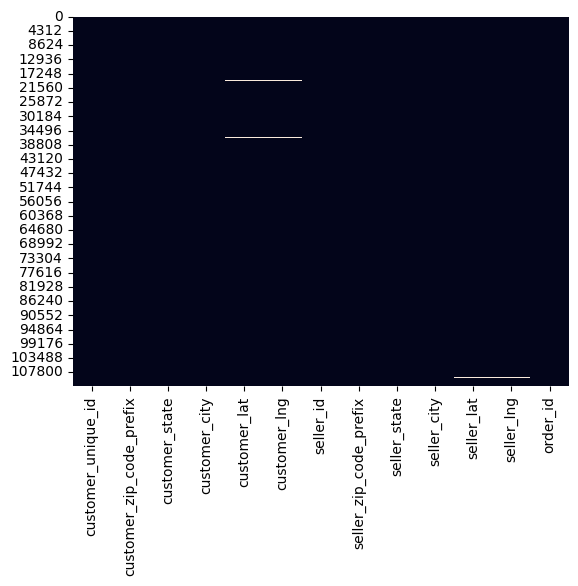

In [ ]:
sns.heatmap(main_coord_tab.isna(), cbar = False)

In [ ]:
main_coord_tab.loc[main_coord_tab.seller_state.isna(), :]

,customer_unique_id,customer_zip_code_prefix,customer_state,customer_city,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_state,seller_city,seller_lat,seller_lng,order_id
8340,55fbb57fd54c35a38c80c2a032a6ca6e,15300,SP,general salgado,-20.646964,-50.362564,None,NaN,None,None,NaN,NaN,b5359909123fa03c50bdb0cfed07f098
10358,2e015e68fbfa36910263df5384e8e45c,73401,DF,brasilia,NaN,NaN,None,NaN,None,None,NaN,NaN,dba5062fbda3af4fb6c33b1e040ca38f
24119,355862aa14375fe3950ee04fef9c7a53,22621,RJ,rio de janeiro,-23.010803,-43.309887,None,NaN,None,None,NaN,NaN,7a4df5d8cff4090e541401a20a22bb80
26169,f15a952dfc52308d0361288fbf42c7b3,91250,RS,porto alegre,-30.022630,-51.105052,None,NaN,None,None,NaN,NaN,a68ce1686d536ca72bd2dadc4b8671e5
62045,10d5890ed5e7ec78a7db23b5ac579b17,93025,RS,sao leopoldo,-29.767455,-51.160058,None,NaN,None,None,NaN,NaN,35de4050331c6c644cddc86f4f2d0d64
64846,6a2da481aa7827b951175772a0fe8bb8,16012,SP,aracatuba,-21.211706,-50.403639,None,NaN,None,None,NaN,NaN,2ce9683175cdab7d1c95bcbb3e36f478
66371,161e5b2b4513edb336986a8909218365,87720,PR,paranavai,-23.069989,-52.415859,None,NaN,None,None,NaN,NaN,90ab3e7d52544ec7bc3363c82689965f
78765,8886115442775dd8a20c2dcc921c7cc8,88070,SC,florianopolis,-27.591471,-48.583157,None,NaN,None,None,NaN,NaN,e04f1da1f48bf2bbffcf57b9824f76e1


Je vérifie le status de commandes qui apparaîssent dans la table order mais pas dans celle des sellers.

In [ ]:
L = main_coord_tab.loc[main_coord_tab.seller_state.isna(), :]['order_id'].tolist()

In [18]:
# tests pour la table des clients
conn = sqlite3.connect(path_data + 'olist.db')
sql = """

  SELECT order_id, order_status
  FROM orders

"""
test_order = pd.read_sql_query(sql, conn)

In [ ]:
test_order.loc[test_order.order_id.isin(L), :].order_status.value_counts()

created     5
invoiced    2
shipped     1
Name: order_status, dtype: int64

In [ ]:
test_order.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

On remarque sur une vue générale que les commandes 'non-disponible' n'apparaîssent pas chez les vendeurs, ce qui en réalité fait sens. Je modifie toutes mes requêtes pour ne pas prendre ces commandes en compte.

In [ ]:
mean_coord_city_tab.head()

,geolocation_city,geolocation_lat_mean,geolocation_lng_mean
0,* cidade,-25.571748,-49.334374
1,...arraial do cabo,-22.969370,-42.029834
2,4o. centenario,-24.271860,-53.069433
3,4º centenario,-24.279801,-53.074723
4,abadia de goias,-16.767063,-49.438089


In [9]:
mean_coord_state_tab.geolocation_state.nunique()

27

In [ ]:
main_coord_tab.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_state',
       'customer_city', 'customer_lat', 'customer_lng', 'seller_id',
       'seller_zip_code_prefix', 'seller_state', 'seller_city', 'seller_lat',
       'seller_lng', 'order_id'],
      dtype='object')

Imputation des customer_lat :

In [ ]:
main_coord_tab.loc[main_coord_tab.customer_lat.isna(), ['customer_zip_code_prefix', 'customer_state',
       'customer_city', 'customer_lat']].isna().mean()

customer_zip_code_prefix    0.0
customer_state              0.0
customer_city               0.0
customer_lat                1.0
dtype: float64

In [ ]:
main_coord_tab.loc[main_coord_tab.customer_lat.isna(), ['customer_city', 'customer_lat']]

,customer_city,customer_lat
501,alto sao joao,NaN
699,brasilia,NaN
780,santo eduardo,NaN
1050,brasilia,NaN
1051,brasilia,NaN
...,...,...
110374,sao mateus,NaN
111463,brasilia,NaN
111680,brasilia,NaN
111797,palmeirinha,NaN


In [34]:
# fonction de remplissage des coordonnées via les zip, city et states
def find_coord(side_to_imp, cat_to_imp, cat_for_imp):
  # initialise zone de traitement
  """
  fonction de remplissage des coordonnées via les zip, city et states :

  side_to_imp = 'customer' # customer, seller
  cat_to_imp = 'lat' # lat, lng
  cat_for_imp = 'city' # city, state, zip_code_prefix

  """
  match cat_for_imp:
    case 'zip_code_prefix':
      tab_ref = mean_coord_zip_tab
    case 'city':
      tab_ref = mean_coord_city_tab
    case 'state':
      tab_ref = mean_coord_state_tab

  list_cat_for_imp = main_coord_tab.loc[main_coord_tab[side_to_imp+'_'+cat_to_imp].isna(), side_to_imp+'_'+cat_for_imp].tolist()
  intermediate_tab_ref = tab_ref.loc[tab_ref['geolocation'+'_'+cat_for_imp].isin(list_cat_for_imp), ['geolocation'+'_'+cat_for_imp, 'geolocation_'+cat_to_imp+'_mean']]
  intermediate_tab_nan = main_coord_tab.loc[main_coord_tab[side_to_imp+'_'+cat_to_imp].isna(), : ].copy()

  # remplissage avant traitement
  remplissage_ini = intermediate_tab_nan[side_to_imp+'_'+cat_to_imp].isna().mean()

  # break si table intermediaire vide
  if intermediate_tab_ref.shape[0] == 0:
    return(f"{cat_for_imp} ne permet pas d'imputer {cat_to_imp}.", 0.0)

  # impute via les villes
  for x in list_cat_for_imp:
    val_ar = intermediate_tab_ref.loc[intermediate_tab_ref['geolocation'+'_'+cat_for_imp] == x, 'geolocation_'+cat_to_imp+'_mean'].values
    if len(val_ar) > 0:
      val = val_ar[0]
      intermediate_tab_nan.loc[intermediate_tab_nan[side_to_imp+'_'+cat_for_imp] == x, side_to_imp+'_'+cat_to_imp] = val

  # applique le résultat
  #main_coord_tab.loc[main_coord_tab.customer_lat.isna(), ['customer_city', 'customer_lat']] = intermediate_tab_nan

  # affiche l'évolution du remplissage
  remplissage_finale = intermediate_tab_nan[side_to_imp+'_'+cat_to_imp].isna().mean()
  display(f'{(remplissage_ini - remplissage_finale) * 100} % de {side_to_imp}_{cat_to_imp} ont été complété avec {side_to_imp}_{cat_for_imp}.')

  remplissage = (remplissage_ini - remplissage_finale) * 100

  return (intermediate_tab_nan, remplissage)

In [11]:
def apply_imputation(side_to_imp, cat_to_imp, intermediate_tab_nan):
  """
  Applique resultat de la fonction find_coord à renseigner via intermediate_tab_nan
  side_to_imp, cat_to_imp : idem que param find_coord
  """
  main_coord_tab.loc[main_coord_tab[side_to_imp+'_'+cat_to_imp].isna(), : ] = intermediate_tab_nan

In [12]:
side_to_imp = 'customer' # customer, seller
cat_to_imp = 'lng' # lat, lng
cat_for_imp = 'zip_code_prefix' # city, state, zip_code_prefix

intermediate_tab_nan = find_coord(side_to_imp, cat_to_imp, cat_for_imp)[0]
if type(intermediate_tab_nan) == str:
  print(intermediate_tab_nan)
else:
  print(intermediate_tab_nan.isna().mean())

zip_code_prefix ne permet pas d'imputer lng.


In [ ]:
find_coord(side_to_imp, cat_to_imp, cat_for_imp)[1]

0.0

In [ ]:
main_coord_tab.isna().mean()

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
customer_lat                0.002658
customer_lng                0.002658
seller_id                   0.000071
seller_zip_code_prefix      0.000071
seller_state                0.000071
seller_city                 0.000071
seller_lat                  0.002319
seller_lng                  0.002319
order_id                    0.000000
dtype: float64

In [ ]:
# applique les résultats
#apply_imputation(side_to_imp, cat_to_imp, intermediate_tab_nan)

In [ ]:
main_coord_tab.isna().mean()

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
customer_lat                0.000000
customer_lng                0.002658
seller_id                   0.000071
seller_zip_code_prefix      0.000071
seller_state                0.000071
seller_city                 0.000071
seller_lat                  0.002319
seller_lng                  0.002319
order_id                    0.000000
dtype: float64

Est-ce que tous les Etats dans la table des customers sont répertorié dans ma table de states construite à partir de geoloc ?

In [ ]:
# récupération des states pour chaque client
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
    SELECT customer_unique_id, customer_state
    FROM customers
"""
all_customer_states = pd.read_sql_query(sql, conn)

In [ ]:
list_ref_states = mean_coord_state_tab.geolocation_state.tolist()

In [ ]:
# nombre de lignes sans filtre sur les states
all_customer_states.shape[0]

99441

In [ ]:
# nombre de ligne en regardant les states de référence
all_customer_states.loc[all_customer_states.customer_state.isin(list_ref_states), : ].shape[0]

99441

Ainsi, si toutes les villes ne sont pas forcément référencées, j'ai au moins les Etats. Je vais donc pouvoir automatiser le calcul des distances car je suis sûr d'obtenir 100% des coordonnées au pire via les states.

In [13]:
main_coord_tab.isna().mean()

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
customer_lat                0.002658
customer_lng                0.002658
seller_id                   0.000071
seller_zip_code_prefix      0.000071
seller_state                0.000071
seller_city                 0.000071
seller_lat                  0.002319
seller_lng                  0.002319
order_id                    0.000000
dtype: float64

In [14]:
# complete toutes les coordonnées manquantes

L_side = ['customer', 'seller']
L_cat_to = ['lat', 'lng']
L_cat_for = ['zip_code_prefix', 'city', 'state']

for side in L_side:
  for cat_to in L_cat_to:
    for cat_for in L_cat_for:

      side_to_imp = side # customer, seller
      cat_to_imp = cat_to # lat, lng
      cat_for_imp = cat_for # city, state, zip_code_prefix

      result = find_coord(side_to_imp, cat_to_imp, cat_for_imp)
      intermediate_tab_nan = result[0]
      remplissage = result[1]

      if remplissage == 100.0:
        apply_imputation(side_to_imp, cat_to_imp, intermediate_tab_nan)
        break
      elif (remplissage > 0.0) and (remplissage < 100.0):
        apply_imputation(side_to_imp, cat_to_imp, intermediate_tab_nan)



'83.89261744966443 % de customer_city ont été complété avec customer_city.'

'100.0 % de customer_state ont été complété avec customer_state.'

'83.89261744966443 % de customer_city ont été complété avec customer_city.'

'100.0 % de customer_state ont été complété avec customer_state.'

'96.92307692307692 % de seller_city ont été complété avec seller_city.'

'96.92307692307692 % de seller_city ont été complété avec seller_city.'

In [15]:
main_coord_tab.isna().mean()

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
customer_lat                0.000000
customer_lng                0.000000
seller_id                   0.000071
seller_zip_code_prefix      0.000071
seller_state                0.000071
seller_city                 0.000071
seller_lat                  0.000071
seller_lng                  0.000071
order_id                    0.000000
dtype: float64

On a pu completer la quasi totalité des coordonnées sauf pour une petite partie des seller.

In [16]:
main_coord_tab.loc[main_coord_tab.seller_lat.isna(), :]

,customer_unique_id,customer_zip_code_prefix,customer_state,customer_city,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_state,seller_city,seller_lat,seller_lng,order_id
8340,55fbb57fd54c35a38c80c2a032a6ca6e,15300,SP,general salgado,-20.646964,-50.362564,None,NaN,None,None,NaN,NaN,b5359909123fa03c50bdb0cfed07f098
10358,2e015e68fbfa36910263df5384e8e45c,73401,DF,brasilia,-15.811073,-47.971705,None,NaN,None,None,NaN,NaN,dba5062fbda3af4fb6c33b1e040ca38f
24119,355862aa14375fe3950ee04fef9c7a53,22621,RJ,rio de janeiro,-23.010803,-43.309887,None,NaN,None,None,NaN,NaN,7a4df5d8cff4090e541401a20a22bb80
26169,f15a952dfc52308d0361288fbf42c7b3,91250,RS,porto alegre,-30.022630,-51.105052,None,NaN,None,None,NaN,NaN,a68ce1686d536ca72bd2dadc4b8671e5
62045,10d5890ed5e7ec78a7db23b5ac579b17,93025,RS,sao leopoldo,-29.767455,-51.160058,None,NaN,None,None,NaN,NaN,35de4050331c6c644cddc86f4f2d0d64
64846,6a2da481aa7827b951175772a0fe8bb8,16012,SP,aracatuba,-21.211706,-50.403639,None,NaN,None,None,NaN,NaN,2ce9683175cdab7d1c95bcbb3e36f478
66371,161e5b2b4513edb336986a8909218365,87720,PR,paranavai,-23.069989,-52.415859,None,NaN,None,None,NaN,NaN,90ab3e7d52544ec7bc3363c82689965f
78765,8886115442775dd8a20c2dcc921c7cc8,88070,SC,florianopolis,-27.591471,-48.583157,None,NaN,None,None,NaN,NaN,e04f1da1f48bf2bbffcf57b9824f76e1


In [19]:
list_bad_order = main_coord_tab.loc[main_coord_tab.seller_lat.isna(), 'order_id'].tolist()
test_order.loc[test_order.order_id.isin(list_bad_order), :].order_status.value_counts()

created     5
invoiced    2
shipped     1
Name: order_status, dtype: int64

Ces vendeurs dont on ne connait pas les coordonnées correspondent à des commandes existantes chez les clients mais pas chez les vendeurs.

Donc dans la table de valeurs manquantes ci-dessus, je vais imputer les coordonnées vendeurs par celles de la ville vendeur la plus fréquente pour chaque ville client donnée.

In [20]:
# récupère les villes clients
list_cust_city = main_coord_tab.loc[main_coord_tab.seller_lat.isna(), 'customer_city'].unique().tolist()

In [26]:
main_coord_tab.loc[main_coord_tab.seller_lat.isna(), ['customer_city', 'seller_lat', 'seller_lng']]

0

In [22]:
# zone à imputer
interm_tab = main_coord_tab.loc[main_coord_tab.seller_lat.isna(), ['customer_city', 'seller_lat', 'seller_lng']].copy()

if interm_tab.shape[0] > 0:

  # parcours les villes pour imputation
  for x in list_cust_city:

    # trouve ville vendeur la plus fréquente pour une ville client donnée
    city = main_coord_tab.loc[main_coord_tab.customer_city == x, 'seller_city'].mode().values[0]
    display(city)

    # récupère les coordonnées de cette ville
    lat = mean_coord_city_tab.loc[mean_coord_city_tab.geolocation_city == x, 'geolocation_lat_mean'].values[0]
    lng = mean_coord_city_tab.loc[mean_coord_city_tab.geolocation_city == x, 'geolocation_lng_mean'].values[0]

    # impute
    interm_tab.loc[interm_tab.customer_city == x, 'seller_lat'] = lat
    interm_tab.loc[interm_tab.customer_city == x, 'seller_lng'] = lng

  # on applique le résultat
  main_coord_tab.loc[main_coord_tab.seller_lat.isna(), ['customer_city', 'seller_lat', 'seller_lng']] = interm_tab

  display(main_coord_tab.isna().mean())

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

,customer_city,seller_lat,seller_lng
8340,general salgado,-20.646964,-50.362564
10358,brasilia,-15.811073,-47.971705
24119,rio de janeiro,-22.914910,-43.312883
26169,porto alegre,-30.049252,-51.188582
62045,sao leopoldo,-29.764806,-51.139326
64846,aracatuba,-21.205556,-50.443194
66371,paranavai,-23.081459,-52.457861
78765,florianopolis,-27.576836,-48.517952


In [23]:
# on applique le résultat
main_coord_tab.loc[main_coord_tab.seller_lat.isna(), ['customer_city', 'seller_lat', 'seller_lng']] = interm_tab

In [24]:
main_coord_tab.isna().mean()

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
customer_lat                0.000000
customer_lng                0.000000
seller_id                   0.000071
seller_zip_code_prefix      0.000071
seller_state                0.000071
seller_city                 0.000071
seller_lat                  0.000000
seller_lng                  0.000000
order_id                    0.000000
dtype: float64

Crée une fonction pour automatiser le tout :

In [35]:
# complete toutes les coordonnées manquantes

def complet_missing_coordinate():

  L_side = ['customer', 'seller']
  L_cat_to = ['lat', 'lng']
  L_cat_for = ['zip_code_prefix', 'city', 'state']

  for side in L_side:
    for cat_to in L_cat_to:
      for cat_for in L_cat_for:

        side_to_imp = side # customer, seller
        cat_to_imp = cat_to # lat, lng
        cat_for_imp = cat_for # city, state, zip_code_prefix

        result = find_coord(side_to_imp, cat_to_imp, cat_for_imp)
        intermediate_tab_nan = result[0]
        remplissage = result[1]

        if remplissage == 100.0:
          apply_imputation(side_to_imp, cat_to_imp, intermediate_tab_nan)
          break
        elif (remplissage > 0.0) and (remplissage < 100.0):
          apply_imputation(side_to_imp, cat_to_imp, intermediate_tab_nan)

  # zone à imputer
  interm_tab = main_coord_tab.loc[main_coord_tab.seller_lat.isna(), ['customer_city', 'seller_lat', 'seller_lng']].copy()

  if interm_tab.shape[0] > 0:

    # parcours les villes pour imputation
    display(f'{interm_tab.shape[0]} coordonnées manquantes sont remplacées par celles des villes : ')
    for x in list_cust_city:

      # trouve ville vendeur la plus fréquente pour une ville client donnée
      city = main_coord_tab.loc[main_coord_tab.customer_city == x, 'seller_city'].mode().values[0]
      display(city)

      # récupère les coordonnées de cette ville
      lat = mean_coord_city_tab.loc[mean_coord_city_tab.geolocation_city == x, 'geolocation_lat_mean'].values[0]
      lng = mean_coord_city_tab.loc[mean_coord_city_tab.geolocation_city == x, 'geolocation_lng_mean'].values[0]

      # impute
      interm_tab.loc[interm_tab.customer_city == x, 'seller_lat'] = lat
      interm_tab.loc[interm_tab.customer_city == x, 'seller_lng'] = lng

    # on applique le résultat
    main_coord_tab.loc[main_coord_tab.seller_lat.isna(), ['customer_city', 'seller_lat', 'seller_lng']] = interm_tab

    display('remplissage final :')
    display(main_coord_tab.isna().mean())

    return main_coord_tab[['customer_unique_id', 'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']].copy()

Nous avons enfin des coordonnées clients et vendeurs pour calculer les distances.

### calculs

In [36]:
dist_coord_tab = complet_missing_coordinate()

'83.89261744966443 % de customer_lat ont été complété avec customer_city.'

'100.0 % de customer_lat ont été complété avec customer_state.'

'83.89261744966443 % de customer_lng ont été complété avec customer_city.'

'100.0 % de customer_lng ont été complété avec customer_state.'

'96.92307692307692 % de seller_lat ont été complété avec seller_city.'

'96.92307692307692 % de seller_lng ont été complété avec seller_city.'

'8 coordonnées manquantes sont remplacées par celles des villes : '

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'sao paulo'

'remplissage final :'

customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_state              0.000000
customer_city               0.000000
customer_lat                0.000000
customer_lng                0.000000
seller_id                   0.000071
seller_zip_code_prefix      0.000071
seller_state                0.000071
seller_city                 0.000071
seller_lat                  0.000000
seller_lng                  0.000000
order_id                    0.000000
dtype: float64

In [ ]:
# tables avec uniquement les coordonnées par customer
#dist_coord_tab = main_coord_tab[['customer_unique_id', 'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']].copy()

In [ ]:
dist_coord_tab.head(), dist_coord_tab.customer_unique_id.nunique()

(                 customer_unique_id  customer_lat  customer_lng  seller_lat  \
 0  7c396fd4830fd04220f754e42b4e5bff    -23.576983    -46.587161  -23.680729   
 1  af07308b275d755c9edb36a90c618231    -12.177924    -44.660711  -19.807681   
 2  3a653a41f6f9fc3d2a113cf8398680e8    -16.745150    -48.514783  -21.363502   
 3  7c142cf63193a1473d2e66489a9ae977     -5.774190    -35.271143  -19.837682   
 4  72632f0f9dd73dfee390c9b22eb56dd6    -23.676370    -46.514627  -23.543395   
 
    seller_lng  
 0  -46.444238  
 1  -43.980427  
 2  -48.229601  
 3  -43.924053  
 4  -46.262086  ,
 94990)

In [122]:
# calcul des distances sur chaque ligne
start1 = time()

distance_values = [distance((dist_coord_tab.customer_lat[i], dist_coord_tab.customer_lng[i]),
                    (dist_coord_tab.seller_lat[i], dist_coord_tab.seller_lng[i])).kilometers
                    for i in tqdm(range(dist_coord_tab.shape[0]))]

stop1 = time()

print(f'{dist_coord_tab.shape[0]} distances calculées en {round(stop1 - start1, 2)} secondes.')

100%|██████████| 112109/112109 [00:47<00:00, 2340.14it/s]

112109 distances calculées en 47.91 secondes.


In [124]:
# aggrégat des distances moyenne par customer dans une même tables
dist_coord_tab['distance'] = distance_values
distance_table = dist_coord_tab.groupby('customer_unique_id')['distance'].mean().reset_index()

In [ ]:
dist_coord_tab.isna().mean(), dist_coord_tab.shape[0], dist_coord_tab.customer_unique_id.nunique()

In [125]:
distance_table

,customer_unique_id,distance
0,0000366f3b9a7992bf8c76cfdf3221e2,110.496092
1,0000b849f77a49e4a4ce2b2a4ca5be3f,22.190341
2,0000f46a3911fa3c0805444483337064,515.379484
3,0000f6ccb0745a6a4b88665a16c9f078,2468.983992
4,0004aac84e0df4da2b147fca70cf8255,154.744091
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,1990.407282
94986,fffea47cd6d3cc0a88bd621562a9d061,1523.628196
94987,ffff371b4d645b6ecea244b27531430a,1524.922045
94988,ffff5962728ec6157033ef9805bacc48,638.851548


In [126]:
distance_table.isna().mean(), distance_table.customer_unique_id.nunique()

(customer_unique_id    0.0
 distance              0.0
 dtype: float64,
 94990)

In [127]:
distance_table.to_csv(path_data + 'distance_table.csv', index=False)

In [65]:
distance_table = pd.read_csv(path_data + 'distance_table.csv')

## catégories produits

### construction de la table

In [103]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  SELECT product_id, product_category_name
  FROM products
"""
products_translation_tab = pd.read_sql_query(sql, conn)

In [ ]:
products_translation_tab.isna().mean()

product_id               0.000000
product_category_name    0.018512
dtype: float64

In [ ]:
products_translation_tab.loc[products_translation_tab.product_category_name.isna(), :]

,product_id,product_category_name
105,a41e356c76fab66334f36de622ecbd3a,None
128,d8dee61c2034d6d075997acef1870e9b,None
145,56139431d72cd51f19eb9f7dae4d1617,None
154,46b48281eb6d663ced748f324108c733,None
197,5fb61f482620cb672f5e586bb132eae9,None
...,...,...
32515,b0a0c5dd78e644373b199380612c350a,None
32589,10dbe0fbaa2c505123c17fdc34a63c56,None
32616,bd2ada37b58ae94cc838b9c0569fecd8,None
32772,fa51e914046aab32764c41356b9d4ea4,None


610 produits n'ont pas de nom.

On les remplacera par 'other'.

On crée la table rassemblant les custer_id et les noms des produits commandés.

In [50]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH customer_order_table AS (
    SELECT c.customer_unique_id, o.order_id
    FROM customers c
    INNER JOIN orders as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
    ),

  product_tab AS (
    SELECT i.product_id, p.product_category_name, i.order_id
    FROM order_items i
    INNER JOIN products AS p
    ON i.product_id = p.product_id
  ),
  product_order_tab AS (
    SELECT p.product_id, p.product_category_name, o.order_id
    FROM orders o
    INNER JOIN product_tab AS p
    ON o.order_id = p.order_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  )

  SELECT c.customer_unique_id, p.product_category_name
  FROM customer_order_table c
  LEFT JOIN product_order_tab AS p
  ON c.order_id = p.order_id

"""
customer_product_name_tab = pd.read_sql_query(sql, conn)

In [ ]:
customer_product_name_tab.isna().mean()

customer_unique_id       0.000000
product_category_name    0.014245
dtype: float64

In [51]:
customer_product_name_tab.shape

(112109, 2)

In [ ]:
customer_product_name_tab.head()

,customer_unique_id,product_category_name
0,7c396fd4830fd04220f754e42b4e5bff,utilidades_domesticas
1,af07308b275d755c9edb36a90c618231,perfumaria
2,3a653a41f6f9fc3d2a113cf8398680e8,automotivo
3,7c142cf63193a1473d2e66489a9ae977,pet_shop
4,72632f0f9dd73dfee390c9b22eb56dd6,papelaria


In [ ]:
customer_product_name_tab.customer_unique_id.nunique()

94990

In [ ]:
customer_product_name_tab.isna().mean()

customer_unique_id       0.000000
product_category_name    0.014245
dtype: float64

In [ ]:
# remplace les manquants par other
customer_product_name_tab.loc[customer_product_name_tab.product_category_name.isna(), 'product_category_name'] = 'other'
customer_product_name_tab.isna().mean()

customer_unique_id       0.0
product_category_name    0.0
dtype: float64

In [ ]:
# group par clients avec la catégorie d'achat la plus fréquente
customer_product_cat = customer_product_name_tab.groupby('customer_unique_id')['product_category_name'].apply(lambda x: x.mode()).reset_index()

Le calcul ci-dessus est beaucoup tro long. Je vais itérer avec une boucle for.

Affectation des commande les plus fréquente par client.

In [ ]:
customers_list = customer_product_name_tab.customer_unique_id.unique().tolist()

modalite_cmd = []
for customer in tqdm(customers_list):

  # le plus commandé
  modalite = customer_product_name_tab.loc[customer_product_name_tab.customer_unique_id == customer, 'product_category_name'].mode().values[0]
  modalite_cmd.append(modalite)

100%|██████████| 94990/94990 [18:46<00:00, 84.30it/s] 


In [ ]:
# on crée la table des achats les plus fréquent par client
data_customer_product = {
    'customer_unique_id' : customers_list,
    'main_product' : modalite_cmd
}
customer_product_tab = pd.DataFrame(data_customer_product)

In [ ]:
customer_product_tab.to_csv(path_data + 'customer_product_tab.csv', index=False)

In [102]:
customer_product_tab = pd.read_csv(path_data + 'customer_product_tab.csv')

In [ ]:
customer_product_tab.main_product.nunique(), product_category_name_translation.shape[0]

(74, 71)

In [104]:
test_cat = customer_product_tab.merge(product_category_name_translation,
                           left_on= 'main_product',
                           right_on= 'product_category_name',
                           how= 'left')

In [105]:
test_cat.loc[test_cat.product_category_name.isna(), :].main_product.unique()

array(['other', 'portateis_cozinha_e_preparadores_de_alimentos',
       'pc_gamer'], dtype=object)

Nous allons traduire 'portateis_cozinha_e_preparadores_de_alimentos' et 'pc_gamer' manuellement :



*   portateis_cozinha_e_preparadores_de_alimentos : portable_kitchen_and_food_preparation_devices
*   pc_gamer : pc_gamer



In [106]:
# traduction anglaise :
test_cat.loc[test_cat.main_product == 'portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_english'] = 'portable_kitchen_and_food_preparation_devices'
test_cat.loc[test_cat.main_product == 'pc_gamer', 'product_category_name_english'] = 'pc_gamer'
test_cat.loc[test_cat.main_product == 'other', 'product_category_name_english'] = 'other'

test_cat.isna().mean()

customer_unique_id               0.00000
main_product                     0.00000
product_category_name            0.01438
product_category_name_english    0.00000
dtype: float64

In [107]:
# crée la table des catégories
product_tab = test_cat[['customer_unique_id', 'product_category_name_english']].copy()
product_tab

,customer_unique_id,product_category_name_english
0,7c396fd4830fd04220f754e42b4e5bff,baby
1,af07308b275d755c9edb36a90c618231,perfumery
2,3a653a41f6f9fc3d2a113cf8398680e8,auto
3,7c142cf63193a1473d2e66489a9ae977,pet_shop
4,72632f0f9dd73dfee390c9b22eb56dd6,stationery
...,...,...
94985,6359f309b166b0196dbf7ad2ac62bb5a,health_beauty
94986,da62f9e57a76d978d02ab5362c509660,baby
94987,737520a9aad80b3fbbdad19b66b37b30,home_appliances_2
94988,5097a5312c8b157bb7be58ae360ef43c,computers_accessories


In [108]:
product_tab.to_csv(path_data + 'product_tab.csv', index=False)

In [109]:
product_tab = pd.read_csv(path_data + 'product_tab.csv')

Je vais ellaborer un système de score RFM pour les catégories afin de pouvoir le ordonner de façon cohérente et les encoder pour la segmentation.

### score d'encodage

Score RFM des catégories.

In [ ]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH product_tab AS (
    SELECT p.product_category_name, i.order_id, i.price
    FROM order_items i
    INNER JOIN products AS p
    ON i.product_id = p.product_id
  ),
  product_order_tab AS (
    SELECT p.product_category_name, o.order_purchase_timestamp, o.order_id, p.price
    FROM orders o
    INNER JOIN product_tab AS p
    ON o.order_id = p.order_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  )
  SELECT product_category_name,
    MIN(julianday((SELECT MAX(order_purchase_timestamp) FROM product_order_tab)) - julianday(order_purchase_timestamp)) AS recency,
    COUNT(order_id) AS frequency,
    AVG(price) as price
  FROM product_order_tab
  GROUP BY product_category_name;

"""
intermediate_score_product = pd.read_sql_query(sql, conn)

In [ ]:
intermediate_score_product.isna().mean()

product_category_name    0.013514
recency                  0.000000
frequency                0.000000
price                    0.000000
dtype: float64

In [ ]:
merge_score_1 = intermediate_score_product.merge(product_category_name_translation,
                           on= 'product_category_name',
                           how= 'left')

In [ ]:
merge_score_1.loc[merge_score_1.product_category_name == 'portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_english'] = 'portable_kitchen_and_food_preparation_devices'
merge_score_1.loc[merge_score_1.product_category_name == 'pc_gamer', 'product_category_name_english'] = 'pc_gamer'
merge_score_1.loc[merge_score_1.product_category_name == 'other', 'product_category_name_english'] = 'other'

merge_score_1.isna().mean()

product_category_name            0.013514
recency                          0.000000
frequency                        0.000000
price                            0.000000
product_category_name_english    0.013514
dtype: float64

In [ ]:
merge_score_1.loc[merge_score_1.product_category_name_english.isna(), 'product_category_name_english'] = 'other'

In [ ]:
merge_score_1.isna().mean()

product_category_name            0.013514
recency                          0.000000
frequency                        0.000000
price                            0.000000
product_category_name_english    0.000000
dtype: float64

In [ ]:
merge_score_2 = merge_score_1[['product_category_name_english',
                               'recency',
                               'frequency',
                               'price']].copy()
merge_score_2

,product_category_name_english,recency,frequency,price
0,other,6.595035,1589,112.380459
1,agro_industry_and_commerce,8.048206,212,342.124858
2,food,4.917199,509,57.452868
3,food_drink,10.548032,276,54.780725
4,art,6.561910,208,116.190577
...,...,...,...,...
69,signaling_and_security,9.890486,199,108.086583
70,tablets_printing_image,85.810567,83,90.703735
71,telephony,5.818322,4527,71.204471
72,fixed_telephony,20.858924,261,221.548697


In [ ]:
merge_score_2.isna().mean()

product_category_name_english    0.0
recency                          0.0
frequency                        0.0
price                            0.0
dtype: float64

In [ ]:
merge_score_2.describe()

,recency,frequency,price
count,74.000000,74.000000,74.000000
mean,20.790366,1514.878378,145.918132
std,46.575511,2553.976502,145.328627
min,0.000000,2.000000,25.342333
25%,5.740249,77.750000,78.511140
50%,8.341794,277.500000,114.502730
75%,11.986725,1664.750000,152.810694
max,350.677245,11097.000000,1098.340542


In [ ]:
# on normalise pour égaliser les poids des terms dans le score
col_transf = ColumnTransformer(transformers= [
                              ('minmax', MinMaxScaler(), ['recency', 'frequency', 'price'])],
                              remainder='passthrough')
# Appliquer la transformation
transformed_data = col_transf.fit_transform(merge_score_2)

# recree tableau
merge_score_2_norm = pd.DataFrame(transformed_data, columns= ['recency', 'frequency', 'price', 'product_category_name_english'])
merge_score_2_norm = merge_score_2_norm[['product_category_name_english', 'recency', 'frequency', 'price']]

In [ ]:
merge_score_2_norm.head()

,product_category_name_english,recency,frequency,price
0,other,0.018807,0.143037,0.081117
1,agro_industry_and_commerce,0.02295,0.018927,0.295231
2,food,0.014022,0.045696,0.029926
3,food_drink,0.030079,0.024696,0.027436
4,art,0.018712,0.018567,0.084668


In [ ]:
a = merge_score_2_norm['recency']
b = merge_score_2_norm['frequency']
c = merge_score_2_norm['price']

merge_score_2_norm['product_score'] = (1 / (1 + a)) + b + c

In [ ]:
merge_score_2_norm.shape[0]

74

In [ ]:
# tri score dans l'ordre croissant
merge_score_2_norm = merge_score_2_norm.sort_values('product_score')

# puis attribut l'index d'encodage
merge_score_2_norm['id_encodage'] = [id for id in range(1, merge_score_2_norm.shape[0] + 1)]
merge_score_2_norm

,product_category_name_english,recency,frequency,price,product_score,id_encodage
68,security_and_services,1.0,0.0,0.10839,0.60839,1
18,cds_dvds_musicals,0.387538,0.001082,0.024977,0.74676,2
47,la_cuisine,0.39496,0.001082,0.113181,0.831129,3
38,fashion_childrens_clothes,0.260749,0.000541,0.042767,0.836487,4
70,tablets_printing_image,0.2447,0.007301,0.060915,0.871622,5
...,...,...,...,...,...,...
55,furniture_decor,0.015586,0.747724,0.058085,1.790462,70
33,sports_leisure,0.014108,0.774042,0.082678,1.842809,71
12,health_beauty,0.013641,0.868139,0.097854,1.952536,72
62,computers,0.033359,0.018116,1.0,1.985834,73


In [ ]:
merge_score_2_norm.to_csv(path_data + 'merge_score_2_norm.csv', index=False)

In [100]:
merge_score_2_norm = pd.read_csv(path_data + 'merge_score_2_norm.csv')

### encodage

In [112]:
# dictionnaire de mapping
dict_product = {str(merge_score_2_norm.product_category_name_english[i]) : merge_score_2_norm.id_encodage[i] for i in range(merge_score_2_norm.shape[0])}

def map_product(x):
  return dict_product[x]

product_cat_tab = product_tab.copy()
product_cat_tab['product_category_name_english'] = list(map(map_product, product_cat_tab.product_category_name_english))

In [113]:
product_cat_tab

,customer_unique_id,product_category_name_english
0,7c396fd4830fd04220f754e42b4e5bff,58
1,af07308b275d755c9edb36a90c618231,59
2,3a653a41f6f9fc3d2a113cf8398680e8,65
3,7c142cf63193a1473d2e66489a9ae977,51
4,72632f0f9dd73dfee390c9b22eb56dd6,56
...,...,...
94985,6359f309b166b0196dbf7ad2ac62bb5a,72
94986,da62f9e57a76d978d02ab5362c509660,58
94987,737520a9aad80b3fbbdad19b66b37b30,60
94988,5097a5312c8b157bb7be58ae360ef43c,69


In [114]:
product_cat_tab.to_csv(path_data + 'product_cat_tab.csv', index=False)

In [54]:
product_cat_tab = pd.read_csv(path_data + 'product_cat_tab.csv')

## states

### récupération de la table

In [116]:
# récupération des states pour chaque client
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
    SELECT customer_unique_id, customer_state
    FROM customers
"""
intermediate_state_customer = pd.read_sql_query(sql, conn)

In [117]:
# on ne récupère que les customers communs à nos tables, prenons la Recency_table :
list_cust = Recency_table.customer_unique_id.tolist()
intermediate_state_customer = intermediate_state_customer.loc[intermediate_state_customer.customer_unique_id.isin(list_cust), :]
intermediate_state_customer.shape[0]

98326

Certains clients passe commande dans plusieurs Etats...

Nous retiendrons celui dans lequel il commandent le plus.

In [118]:
intermediate_state_customer.isna().mean()

customer_unique_id    0.0
customer_state        0.0
dtype: float64

In [ ]:
customers_list = intermediate_state_customer.customer_unique_id.unique().tolist()

modalite_state = []
for customer in tqdm(customers_list):

  # Etat le plus fréquent par client
  modalite = intermediate_state_customer.loc[intermediate_state_customer.customer_unique_id == customer, 'customer_state'].mode().values[0]
  modalite_state.append(modalite)

# on crée la table des Etats les plus fréquent par client
data_customer_state = {
    'customer_unique_id' : customers_list,
    'main_state' : modalite_state
}
customer_state_tab = pd.DataFrame(data_customer_state)

customer_state_tab.to_csv(path_data + 'customer_state_tab.csv', index=False)

In [ ]:
customer_state_tab = pd.read_csv(path_data + 'customer_state_tab.csv')

In [ ]:
customer_state_tab

In [ ]:
customer_state_tab.main_state.nunique()

### score d'encodage

Score RFM des states.

In [ ]:
conn = sqlite3.connect(path_data + 'olist.db')
sql = """
  WITH price_tab AS (
    SELECT i.order_id, i.price
    FROM orders o
    INNER JOIN order_items AS i
    ON i.order_id = o.order_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  ),
  rf_state_tab AS (
    SELECT c.customer_state, o.order_purchase_timestamp, o.order_id
    FROM orders o
    INNER JOIN customers AS c
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
  ),
  rfm_tab AS (
    SELECT r.customer_state, r.order_purchase_timestamp, r.order_id, p.price
    FROM rf_state_tab r
    INNER JOIN price_tab AS p
    ON r.order_id = p.order_id
  )

  SELECT customer_state,
    MIN(julianday((SELECT MAX(order_purchase_timestamp) FROM rfm_tab)) - julianday(order_purchase_timestamp)) AS recency,
    COUNT(order_id) AS frequency,
    AVG(price) as price
  FROM rfm_tab
  GROUP BY customer_state;

"""
intermediate_state_tab = pd.read_sql_query(sql, conn)

In [ ]:
intermediate_state_tab

,customer_state,recency,frequency,price
0,AC,12.691100,92,173.727717
1,AL,19.361736,444,180.889212
2,AM,19.700058,165,135.496000
3,AP,18.034514,82,164.320732
4,BA,12.404491,3785,133.978555
5,CE,10.974051,1474,153.503433
6,DF,7.436794,2397,125.526262
7,ES,8.670694,2248,121.677994
8,GO,9.634479,2323,123.921851
9,MA,10.512188,820,145.477585


In [ ]:
# on normalise pour égaliser les poids des terms dans le score
col_transf = ColumnTransformer(transformers= [
                              ('minmax', MinMaxScaler(), ['recency', 'frequency', 'price'])],
                              remainder='passthrough')
# Appliquer la transformation
transformed_data = col_transf.fit_transform(intermediate_state_tab)

# recree tableau
intermediate_state_tab_norm = pd.DataFrame(transformed_data, columns= ['recency', 'frequency', 'price', 'state'])
intermediate_state_tab_norm = intermediate_state_tab_norm[['state', 'recency', 'frequency', 'price']]
intermediate_state_tab_norm

,state,recency,frequency,price
0,AC,0.305684,0.00087,0.783643
1,AL,0.466357,0.008344,0.871038
2,AM,0.474506,0.00242,0.317083
3,AP,0.434389,0.000658,0.668845
4,BA,0.298781,0.079275,0.298565
5,CE,0.264327,0.030211,0.536836
6,DF,0.179127,0.049807,0.195417
7,ES,0.208847,0.046643,0.148455
8,GO,0.232061,0.048236,0.175838
9,MA,0.253202,0.016326,0.438893


In [ ]:
# calcul du score
a = intermediate_state_tab_norm['recency']
b = intermediate_state_tab_norm['frequency']
c = intermediate_state_tab_norm['price']

intermediate_state_tab_norm['state_score'] = (1 / (1 + a)) + b + c

# tri score dans l'ordre croissant
intermediate_state_tab_norm = intermediate_state_tab_norm.sort_values('state_score')

# puis attribut l'index d'encodage
intermediate_state_tab_norm['id_encodage'] = [id for id in range(1, intermediate_state_tab_norm.shape[0] + 1)]
intermediate_state_tab_norm

,state,recency,frequency,price,state_score,id_encodage
2,AM,0.474506,0.00242,0.317083,0.997696,1
21,RR,1.0,0.0,0.515484,1.015484,2
7,ES,0.208847,0.046643,0.148455,1.022333,3
8,GO,0.232061,0.048236,0.175838,1.035722,4
6,DF,0.179127,0.049807,0.195417,1.09331,5
17,PR,0.115223,0.120335,0.107926,1.124942,6
22,RS,0.1396,0.13078,0.122554,1.130836,7
23,SC,0.159263,0.087257,0.184459,1.134333,8
4,BA,0.298781,0.079275,0.298565,1.147792,9
11,MS,0.304615,0.016284,0.405385,1.188179,10


In [ ]:
intermediate_state_tab_norm.to_csv(path_data + 'intermediate_state_tab_norm.csv', index=False)

In [101]:
intermediate_state_tab_norm = pd.read_csv(path_data + 'intermediate_state_tab_norm.csv')

### encodage

In [ ]:
# dictionnaire de mapping
dict_state = {str(intermediate_state_tab_norm.state[i]) : intermediate_state_tab_norm.id_encodage[i] for i in range(intermediate_state_tab_norm.shape[0])}

def map_state(x):
  return dict_state[x]

state_tab = customer_state_tab.copy()
state_tab['main_state'] = list(map(map_state, customer_state_tab.main_state))

In [99]:
state_tab

,customer_unique_id,main_state
0,861eff4711a542e4b93843c6dd7febb0,27
1,290c77bc529b7ac935b93aa66c333dc3,27
2,060e732b5b29e8181a18229c7b0b2b5e,27
3,259dac757896d24d7702b9acbbff3f3c,27
4,345ecd01c38d18a9036ed96c73b8d066,27
...,...,...
94985,1a29b476fee25c95fbafc67c5ac95cf8,27
94986,d52a67c98be1cf6a5c84435bd38d095d,27
94987,e9f50caf99f032f0bf3c55141f019d99,18
94988,73c2643a0a458b49f58cea58833b192e,7


In [120]:
state_tab.to_csv(path_data + 'state_tab.csv', index=False)

In [55]:
state_tab = pd.read_csv(path_data + 'state_tab.csv')

# Analyse exploratoire

## concatenation des features

### merge avec la table commune

In [83]:
# les tables de features
a = sql_segmentation_tab.copy()
b = distance_table.copy()
c = product_cat_tab.copy()
d = state_tab.copy()

Segmentation_tab = a.merge(b, on= 'customer_unique_id', how= 'left')
Segmentation_tab = Segmentation_tab.merge(c, on= 'customer_unique_id', how= 'left')
Segmentation_tab = Segmentation_tab.merge(d, on= 'customer_unique_id', how= 'left')

Segmentation_tab

,customer_unique_id,recency,frequency,monetary,satisfaction_mean,installment_mean,distance,product_category_name_english,main_state
0,0000366f3b9a7992bf8c76cfdf3221e2,115.923958,1,141.90,5.0,8.0,110.496092,74,27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.913542,1,27.19,4.0,1.0,22.190341,72,27
2,0000f46a3911fa3c0805444483337064,541.501319,1,86.22,3.0,8.0,515.379484,56,8
3,0000f6ccb0745a6a4b88665a16c9f078,325.525880,1,43.62,4.0,4.0,2468.983992,61,23
4,0004aac84e0df4da2b147fca70cf8255,292.556424,1,196.89,5.0,6.0,154.744091,61,27
...,...,...,...,...,...,...,...,...,...
94299,fffcf5a5ff07b0908bd4e2dbc735a684,451.504410,1,2067.42,5.0,10.0,1990.407282,72,12
94300,fffea47cd6d3cc0a88bd621562a9d061,266.540984,1,84.58,4.0,1.0,1523.628196,58,9
94301,ffff371b4d645b6ecea244b27531430a,572.720613,1,112.46,5.0,1.0,1524.922045,65,15
94302,ffff5962728ec6157033ef9805bacc48,123.742546,1,133.69,5.0,5.0,638.851548,68,3


In [84]:
Segmentation_tab.to_csv(path_data + 'Segmentation_tab.csv', index=False)

In [60]:
Segmentation_tab = pd.read_csv(path_data + 'Segmentation_tab.csv')

### merge avec les tables individuelles

In [130]:
# les tables de features
customer_id = Recency_table.customer_unique_id
a = Recency_table.copy()
b = Frequency_table.copy()
c = Monetary_table.copy()
d = Satisfation_table.copy()
e = installment_table.copy()
f = distance_table.copy()
g = product_cat_tab.copy()
h = state_tab.copy()

Segmentation_tab_b = a.merge(b, on= 'customer_unique_id', how= 'left')

for tab in [c, d, e, f, g, h]:

  Segmentation_tab_b = Segmentation_tab_b.merge(tab, on= 'customer_unique_id', how= 'left')

Segmentation_tab_b

,customer_unique_id,recency,frequency,monetary,satisfaction_mean,installment_mean,distance,product_category_name_english,main_state
0,0000366f3b9a7992bf8c76cfdf3221e2,115.923958,1,141.90,5.0,8.0,110.496092,74,27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.913542,1,27.19,4.0,1.0,22.190341,72,27
2,0000f46a3911fa3c0805444483337064,541.501319,1,86.22,3.0,8.0,515.379484,56,8
3,0000f6ccb0745a6a4b88665a16c9f078,325.525880,1,43.62,4.0,4.0,2468.983992,61,23
4,0004aac84e0df4da2b147fca70cf8255,292.556424,1,196.89,5.0,6.0,154.744091,61,27
...,...,...,...,...,...,...,...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,451.504410,1,2067.42,5.0,10.0,1990.407282,72,12
94986,fffea47cd6d3cc0a88bd621562a9d061,266.540984,1,84.58,4.0,1.0,1523.628196,58,9
94987,ffff371b4d645b6ecea244b27531430a,572.720613,1,112.46,5.0,1.0,1524.922045,65,15
94988,ffff5962728ec6157033ef9805bacc48,123.742546,1,133.69,5.0,5.0,638.851548,68,3


In [131]:
Segmentation_tab_b.isna().mean()

customer_unique_id               0.000000
recency                          0.000000
frequency                        0.000000
monetary                         0.000011
satisfaction_mean                0.007211
installment_mean                 0.000011
distance                         0.000000
product_category_name_english    0.000000
main_state                       0.000000
dtype: float64

Nous avions vu qu'ils manquaient 1 client dans les tables Monetary et Installment ainsi que quelques notes de satisfactions dans satisfaction_mean, nous allons les supprimer comme ils sont peu nombreux, cela n'aura pas d'impact significatif sur nos analyses.

In [133]:
Segmentation_tab_b = Segmentation_tab_b.dropna()

In [134]:
Segmentation_tab_b.to_csv(path_data + 'Segmentation_tab_b.csv', index=False)

In [57]:
Segmentation_tab_b = pd.read_csv(path_data + 'Segmentation_tab_b.csv')

In [58]:
Segmentation_tab_b

,customer_unique_id,recency,frequency,monetary,satisfaction_mean,installment_mean,distance,product_category_name_english,main_state
0,0000366f3b9a7992bf8c76cfdf3221e2,115.923958,1,141.90,5.0,8.0,110.496092,74,27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.913542,1,27.19,4.0,1.0,22.190341,72,27
2,0000f46a3911fa3c0805444483337064,541.501319,1,86.22,3.0,8.0,515.379484,56,8
3,0000f6ccb0745a6a4b88665a16c9f078,325.525880,1,43.62,4.0,4.0,2468.983992,61,23
4,0004aac84e0df4da2b147fca70cf8255,292.556424,1,196.89,5.0,6.0,154.744091,61,27
...,...,...,...,...,...,...,...,...,...
94299,fffcf5a5ff07b0908bd4e2dbc735a684,451.504410,1,2067.42,5.0,10.0,1990.407282,72,12
94300,fffea47cd6d3cc0a88bd621562a9d061,266.540984,1,84.58,4.0,1.0,1523.628196,58,9
94301,ffff371b4d645b6ecea244b27531430a,572.720613,1,112.46,5.0,1.0,1524.922045,65,15
94302,ffff5962728ec6157033ef9805bacc48,123.742546,1,133.69,5.0,5.0,638.851548,68,3


## Analyse

In [85]:
Segmentation_tab.columns

Index(['customer_unique_id', 'recency', 'frequency', 'monetary',
       'satisfaction_mean', 'installment_mean', 'distance',
       'product_category_name_english', 'main_state'],
      dtype='object')

est-ce que la catégorie d'achat a un impact sur la satisfaction client ?
___________________________________________________________________________

Text(0.5, 1.0, 'Satisfaction moyenne par catégorie de produit')

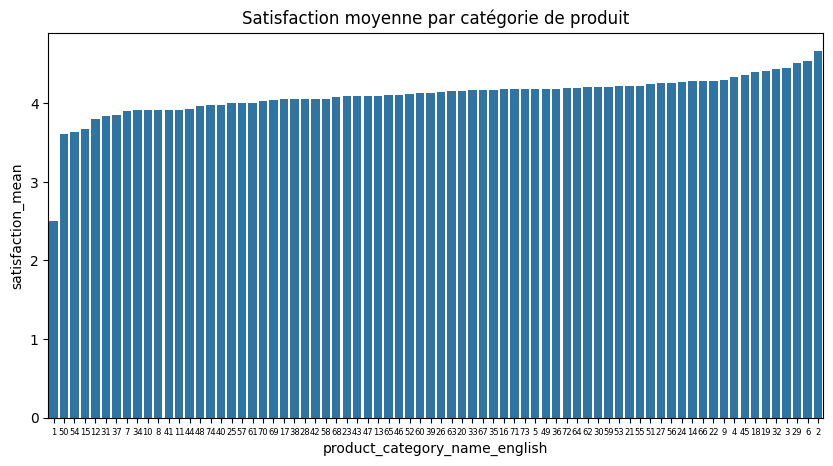

In [86]:
data_product_satisfaction = Segmentation_tab.groupby('product_category_name_english')['satisfaction_mean'].mean().reset_index().sort_values('satisfaction_mean')
plt.figure(figsize= (10, 5))
sns.barplot(data= data_product_satisfaction,
            x= data_product_satisfaction.product_category_name_english.map(str),
            y= 'satisfaction_mean')
plt.tick_params(axis='x', labelsize=6)
plt.title('Satisfaction moyenne par catégorie de produit')

On remarque effectivement une différence de satisfaction moyenne par catégorie de produit, notamment pour la 1.

est-ce que le montant cumulé d'achats est lié à un nombre de versements plus important pour les paiements ?
__________________________

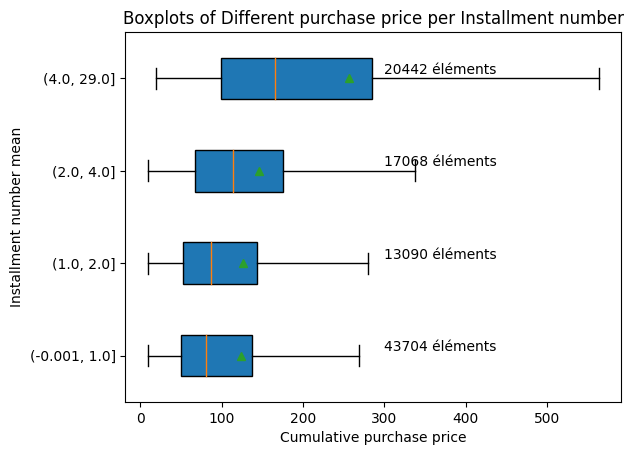

In [87]:
# Discretize the 'installments_mean' column into quartiles
data_montant_paiement = pd.qcut(Segmentation_tab.installment_mean, 4)

# Get the unique intervals and sort them
unique_intervals = data_montant_paiement.unique().sort_values()

# Create a dictionary to store the filtered data
D = {str(category): Segmentation_tab[
        (Segmentation_tab['installment_mean'] >= category.left) &
        (Segmentation_tab['installment_mean'] <= category.right)
         ]['monetary'].tolist() for category in unique_intervals}

ticks_interval = data_montant_paiement.value_counts().sort_index().values

plt.figure()
plt.boxplot([D[C] for C in D],vert=False,showmeans=True,showfliers=False,patch_artist = True,labels=[C for C in D])
plt.title('Boxplots of Different purchase price per Installment number')
plt.xlabel('Cumulative purchase price')
plt.ylabel('Installment number mean')

for i in range(len(ticks_interval)):
  plt.text(x= 300,y= i+1.05, s= f'{ticks_interval[i]} éléments')

plt.show()

Plus le nombre de paiement est élévé plus le montant est élevé

est-ce que la distance moyenne entre un client et les vendeurs des produits qu'il achète influence sa fréquence d'achat ?
___________________________

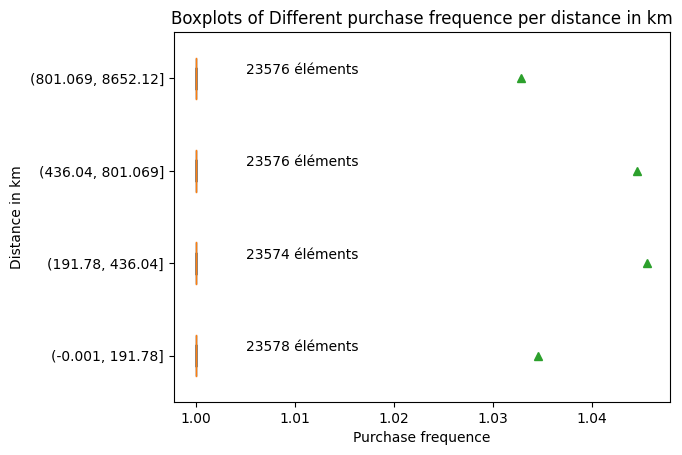

In [88]:
# Discretize the 'installments_mean' column into quartiles
data_distance_frequence = pd.qcut(Segmentation_tab.distance, 4)

# Get the unique intervals and sort them
unique_intervals = data_distance_frequence.unique().sort_values()

# Create a dictionary to store the filtered data
D = {str(category): Segmentation_tab[
        (Segmentation_tab['distance'] >= category.left) &
        (Segmentation_tab['distance'] <= category.right)
         ]['frequency'].tolist() for category in unique_intervals}

ticks_interval = data_distance_frequence.value_counts().sort_index().values

plt.figure()
plt.boxplot([D[C] for C in D],vert=False,showmeans=True,showfliers=False,patch_artist = True,labels=[C for C in D])
plt.title('Boxplots of Different purchase frequence per distance in km')
plt.xlabel('Purchase frequence')
plt.ylabel('Distance in km')

for i in range(len(ticks_interval)):
  plt.text(x= 1.005,y= i+1.05, s= f'{ticks_interval[i]} éléments')

plt.show()

En moyenne nous n'observons pas d'évolution linéaire entre la fréquence d'achat et la distance entre client et vendeur.

Regardons plutôt les fréquence max par éloignement :

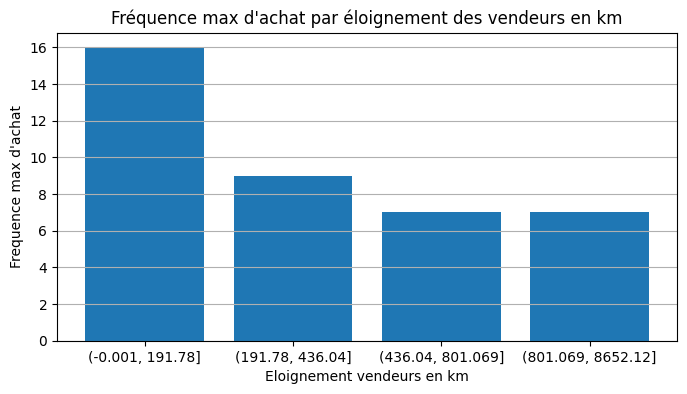

In [89]:
D_dist_freq_mean = {str(category): Segmentation_tab[
        (Segmentation_tab['distance'] >= category.left) &
        (Segmentation_tab['distance'] <= category.right)
         ]['frequency'].max() for category in unique_intervals}

plt.figure(figsize= (8, 4))
plt.bar(x= [C for C in D_dist_freq_mean], height= [D_dist_freq_mean[C] for C in D_dist_freq_mean])
plt.title("Fréquence max d'achat par éloignement des vendeurs en km")
plt.ylabel("Frequence max d'achat")
plt.xlabel('Eloignement vendeurs en km')
plt.grid(axis= 'y')

Sous cet angle, on observe que la fréquence d'achat maximale est deux fois plus élevée lorsque le client est proche d'une vendeur.

est-ce que la catégorie d'un produit est liée à une fréquence d'achat élevé ?
_______________________

In [90]:
data_product_frequence = Segmentation_tab.groupby('product_category_name_english')['frequency'].mean().reset_index().sort_values('frequency')
colors = ['blue' for i in range(69)] + ['red' for i in range(5)]

<ipython-input-91-a666581a2707>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= data_product_frequence,


Text(0.5, 1.0, "Fréquence moyenne d'achat par catégorie de produit")

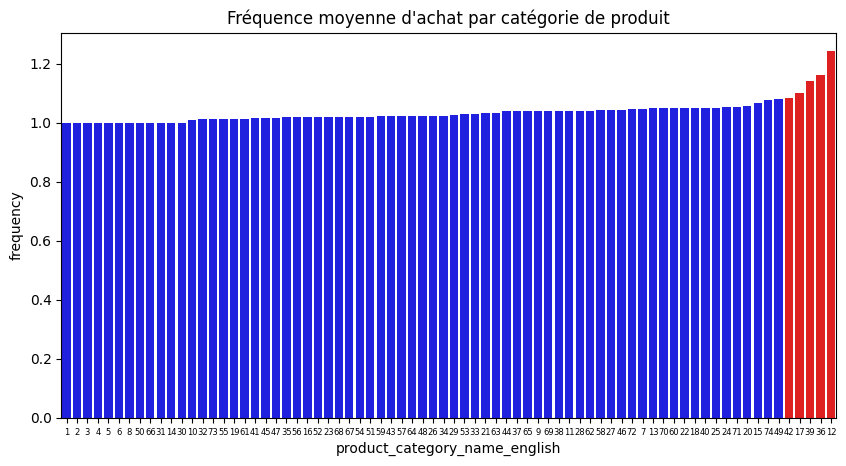

In [91]:
plt.figure(figsize= (10, 5))
sns.barplot(data= data_product_frequence,
            x= data_product_frequence.product_category_name_english.map(str),
            y= 'frequency',
            palette= colors)
plt.tick_params(axis='x', labelsize=6)
plt.title("Fréquence moyenne d'achat par catégorie de produit")

Comme dans la visualisation précédente, étant donné que la très grande majorité des clients n'ont passé qu'une seule commande, la moyenne des fréquences ne permet pas vraiment d'observer des choses intéressantes sur l'ensemble des catégories de produits.

On remarque cependant que les 4 catégories de produits à droite du graphique sont plus populaires : [42, 17, 36, 39, 12]

Voyons plutôt les fréquance maximale d'achat par catégorie de produit.

In [92]:
data_product_frequence_color = data_product_frequence.copy()
data_product_frequence_color['colors'] = colors
data_product_frequence_color = data_product_frequence_color[['product_category_name_english', 'colors']]
dict_product_frequence_color = {
    data_product_frequence_color.product_category_name_english[i] : data_product_frequence_color.colors[i] for i in range(data_product_frequence_color.shape[0])
}

In [93]:
def attrib_color(x):
  return dict_product_frequence_color[x]

In [94]:
data_product_frequence_max = Segmentation_tab.groupby('product_category_name_english')['frequency'].max().reset_index().sort_values('frequency')

In [95]:
data_product_frequence_max['colors'] = data_product_frequence_max.product_category_name_english
data_product_frequence_max.colors = data_product_frequence_max.colors.map(attrib_color)
data_product_frequence_max

,product_category_name_english,frequency,colors
0,1,1,blue
13,14,1,blue
65,66,1,blue
49,50,1,blue
30,31,1,blue
...,...,...,...
63,64,7,blue
64,65,7,blue
69,70,7,blue
73,74,9,blue


<ipython-input-96-018495cd6da3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= data_product_frequence_max,


Text(0.5, 1.0, "Fréquence maximale d'achat par catégorie de produit")

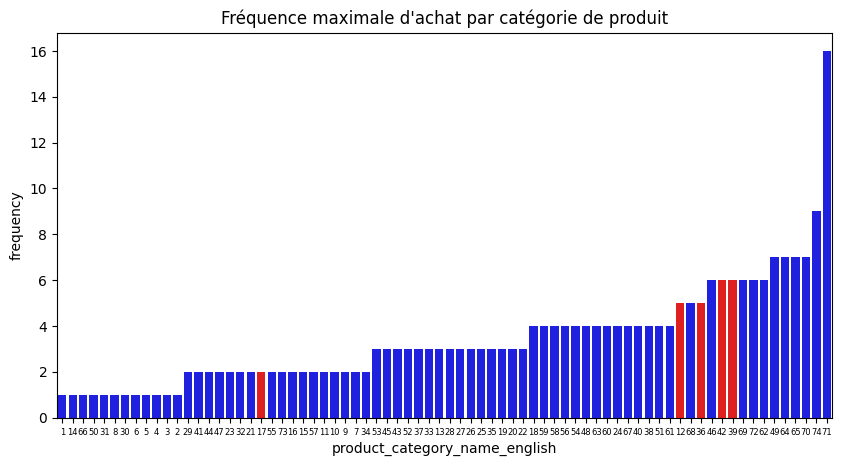

In [96]:
plt.figure(figsize= (10, 5))
sns.barplot(data= data_product_frequence_max,
            x= data_product_frequence_max.product_category_name_english.map(str),
            y= 'frequency',
            palette= data_product_frequence_max.colors.tolist())
plt.tick_params(axis='x', labelsize=6)
plt.title("Fréquence maximale d'achat par catégorie de produit")

Les catégories d'achat populaires en moyenne ne sont pas celles qui ont localement étaient le plus commandées.

Dans quelles Etat se concentrent la plupart des clients ?
__________________

In [97]:
Segmentation_tab.columns

Index(['customer_unique_id', 'recency', 'frequency', 'monetary',
       'satisfaction_mean', 'installment_mean', 'distance',
       'product_category_name_english', 'main_state'],
      dtype='object')

Text(0.5, 1.0, 'Nombre de clients par Etat')

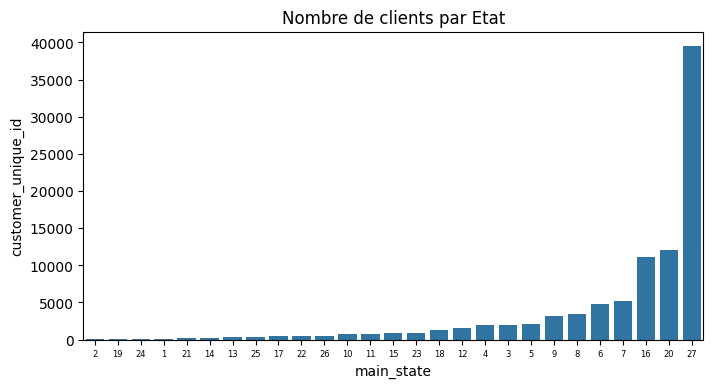

In [98]:
data_state_count = Segmentation_tab.groupby('main_state')['customer_unique_id'].count().reset_index().sort_values('customer_unique_id')
plt.figure(figsize= (8, 4))
sns.barplot(data= data_state_count,
            x= data_state_count.main_state.map(str),
            y= data_state_count.customer_unique_id)
plt.tick_params(axis='x', labelsize=6)
plt.title('Nombre de clients par Etat')

L'Etat 27 (Sao Paolo) concentre près de la moitié des clients.

Quel Etat est en moyenne le plus satisfait ?
__________________

Text(0.5, 1.0, 'Satisfaction moyenne des clients par Etat')

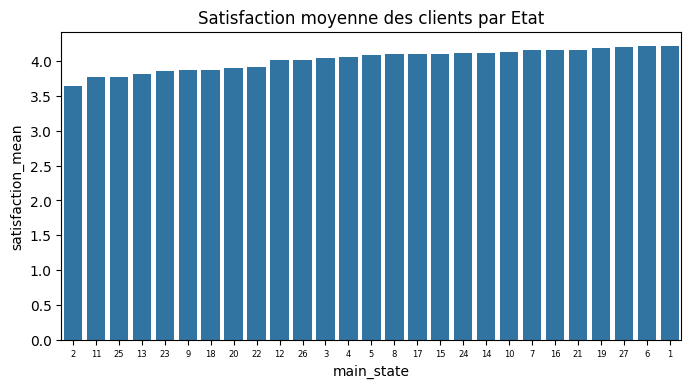

In [99]:
data_state_satisfaction = Segmentation_tab.groupby('main_state')['satisfaction_mean'].mean().reset_index().sort_values('satisfaction_mean')
plt.figure(figsize= (8, 4))
sns.barplot(data= data_state_count,
            x= data_state_satisfaction.main_state.map(str),
            y= data_state_satisfaction.satisfaction_mean)
plt.tick_params(axis='x', labelsize=6)
plt.title('Satisfaction moyenne des clients par Etat')

In [103]:
dict_state

{'AM': 1,
 'RR': 2,
 'ES': 3,
 'GO': 4,
 'DF': 5,
 'PR': 6,
 'RS': 7,
 'SC': 8,
 'BA': 9,
 'MS': 10,
 'MA': 11,
 'PE': 12,
 'SE': 13,
 'TO': 14,
 'MT': 15,
 'MG': 16,
 'RN': 17,
 'CE': 18,
 'AP': 19,
 'RJ': 20,
 'RO': 21,
 'PI': 22,
 'PA': 23,
 'AC': 24,
 'AL': 25,
 'PB': 26,
 'SP': 27}

En moyenne les clients de l'Etat de manaus sont les plus satisfaits.

Dans quelles Etat les clients commandes à des vendeurs éloignés en distance moyenne?
__________________

In [104]:
Segmentation_tab.columns

Index(['customer_unique_id', 'recency', 'frequency', 'monetary',
       'satisfaction_mean', 'installment_mean', 'distance',
       'product_category_name_english', 'main_state'],
      dtype='object')

Text(0.5, 1.0, 'Eloignement moyen en km entre les clients et leur vendeur par Etat')

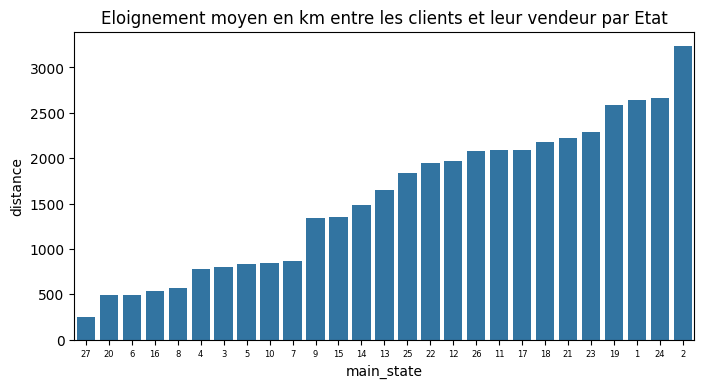

In [105]:
data_state_distance = Segmentation_tab.groupby('main_state')['distance'].mean().reset_index().sort_values('distance')
plt.figure(figsize= (8, 4))
sns.barplot(data= data_state_distance,
            x= data_state_distance.main_state.map(str),
            y= data_state_distance.distance)
plt.tick_params(axis='x', labelsize=6)
plt.title('Eloignement moyen en km entre les clients et leur vendeur par Etat')

Dans l'Etat de Sao Paolo, les clients commande en moyenne à des vendeurs proche d'eux tandis que dans le Roraima ils commande à des clients éloignés.

Le Roraima est un Etat asez excentré au Brésil (le plus au nord). Cela n'est pas l'objet de ce projet mais nous pourrions par exemple comparer les localisations des clients dans cette zone à celles des vendeurs auprès desquels ils passent commande.